# Introduction to the notebook

This notebook assesses performance on the test set while using all information available.
 
The parameters used were chosen based on hyperparameter tuning that optimised the average 5-fold validation F1-macro score.

## Imports

In [9]:
import os

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from statistics import mean
import matplotlib
from tqdm import tqdm
from datetime import datetime

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torch.optim import lr_scheduler

plt.style.use('seaborn')

import DiagnosisFunctions.tools as tools

import torchvision.models as models

import albumentations as A
import torchvision.transforms.functional as TF
from sklearn.model_selection import KFold
import time
import pickle

import CNNmodels as CNNmodels

In [10]:
#Set the notebook to run on the GPU, if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'This notebook is running on the {device.type}.')

if device.type == 'cuda':
    print(f"Running on device {torch.cuda.current_device()}")
    print('')

This notebook is running on the cpu.


In [11]:
(train_path, train_target), (test_path, test_target) = tools.get_splits_characteristics()

train_set = tools.CharacteristicsDataset(path = train_path, target = train_target, size = [200, 200])
test_set = tools.CharacteristicsDataset(path = test_path, target = test_target, size = [200, 200])

## Training

We use a custom loss function that puts weights on characteristics, diagnosis and area. This is done to later assess the importance each of the variables through hyperparameter tuning.

In [4]:
class WeightedBCELoss():
    def __init__(self, weights=[1, 1, 1]):
        self.weights = weights
        self.criterion = nn.BCELoss()

    def __call__(self, probabilities, targets):
        loss_characteristics = self.criterion(probabilities[:, :7], targets[:, :7]) 
        loss_diagnosis       = self.criterion(probabilities[:, 7:13], targets[:, 7:13]) 
        loss_area            = self.criterion(probabilities[:, 13:], targets[:, 13:])

        return self.weights[0] * loss_characteristics + self.weights[1] * loss_diagnosis + self.weights[2] * loss_area

In [1]:
def train_and_eval(phase, model, optimizer, criterion, scheduler, dataloaders):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0

    #Preallocate the probabilities dataframe.
    probabilities = pd.DataFrame(columns = dataloaders[phase].dataset.variables)
    ground_truth  = pd.DataFrame(columns = dataloaders[phase].dataset.variables)

    for inputs, targets, _ in dataloaders[phase]:
        inputs  = inputs.to(device)
        targets = targets.to(device).float()

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        #Append to the dataframes
        probabilities = probabilities.append(pd.DataFrame(outputs.detach().cpu().numpy(), columns = dataloaders[phase].dataset.variables), ignore_index=True)
        ground_truth  = ground_truth.append(pd.DataFrame(targets.detach().cpu().numpy(), columns  = dataloaders[phase].dataset.variables), ignore_index=True)

    if phase == 'train':
        scheduler.step()

    #Return the total loss.
    return running_loss, ground_truth, probabilities

In [ ]:
criterion = WeightedBCELoss(weights=[0.41072483896743606, 0.6142489137204648, 0.17056242939212682])
lr = 0.0003213711824536609
train_loader = DataLoader(train_set, batch_size=56)
test_loader = DataLoader(test_set, batch_size=56)

dataloaders = {'train': train_loader, 'test': test_loader}

cnn = CNNmodels.CNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss = {'train': [], 'test': []}
f1_diagnosis = {'train': [], 'test': []}

for epoch in tqdm(range(20), unit='epoch'):
    for phase in ['train', 'test']:
        epoch_loss, gt, p = train_and_eval(phase, cnn, optimizer, criterion, scheduler, dataloaders)

        avg_obs_loss = (epoch_loss / len(dataloaders[phase].dataset)) 

        loss[phase].append(avg_obs_loss)

        # Predict labels based on probabilities
        pred_class = tools.classify_probability_predictions(p.copy())
        
        # Compute f1 scores with average 'samples' (default values)
        metric_dict = tools.compute_metrics_scores(gt, pred_class)
        
        f1_diagnosis[phase].append(metric_dict['diagnosis'])

In [ ]:
with open('final_model.p', 'wb') as output_model:
    pickle.dump((cnn.to('cpu'), (loss, f1_diagnosis)), output_model)

## Performance assessment

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
with open('final_model.p', 'rb') as input_model:
    model_file = pickle.load(input_model)

In [2]:
model, (loss, f1_diagnosis) = model_file

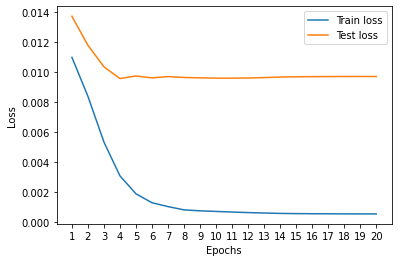

In [3]:
plt.figure(figsize=(6,4))
plt.plot(loss['train'], label='Train loss')
plt.plot(loss['test'], label='Test loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(20),range(1,21))
plt.savefig("loss_plot.pdf")
plt.show()

In [41]:
test_loader = DataLoader(test_set, batch_size=83)
inputs, target, _ = next(iter(dataloaders['test']))
outputs = model(inputs)

preds = [torch.argmax(x) for x in outputs[:, 7:13]]
targets = [torch.argmax(x) for x in target[:, 7:13]]

In [84]:
disp = ConfusionMatrixDisplay(confusion_matrix(targets, preds, normalize='pred'), display_labels=test_loader.dataset.variables[7:13])
disp.plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()